In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('balikpapan_weather.csv')
df.head()

In [ ]:
df.info()

In [ ]:
df.describe()

In [7]:
data = df[['Date', 'Temp']]
data = data.set_index('Date')

In [8]:
# minmax scaler
scaler = MinMaxScaler(feature_range = (0, 1))
data_1 = scaler.fit_transform(data)

In [9]:
train_size = int(len(data_1)*0.8)
test_size = len(data_1) - train_size
X_data, y_data = data_1[0: train_size, :], data_1[train_size: len(data_1), :1]
train_size, test_size

(577, 145)

In [10]:
def dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [11]:
# split data
X_train, y_train = dataset(X_data, 100)
X_test, y_test = dataset(y_data, 100)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [12]:
threshold = (data['Temp'].max() - data['Temp'].min()) * 10/100
print(threshold)

0.13000000000000006


In [13]:
# create model
model = Sequential([
    LSTM(128, return_sequences = True, input_shape=(100, 1)),
    Dropout(0.1),
    LSTM(128, return_sequences = True),
    Dropout(0.1),
    Bidirectional(LSTM(16)),
    Dropout(0.1),
    Dense(4, activation = 'relu'),
    Dense(1)
])
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f16f5c64610>>

In [14]:
# callback
auto_stop_learn = EarlyStopping(
    monitor = 'loss',
    min_delta = 0,
    patience = 2,
    verbose = 1,
    mode = 'auto'
)

In [15]:
# train model
optimizer = 'adam'
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"]
)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 128,
    callbacks = auto_stop_learn,
    verbose = 1
)

Epoch 1/100
4/4 [==============================] - 19s 2s/step - loss: 0.1478 - mae: 0.5062 - val_loss: 0.0176 - val_mae: 0.1228
Epoch 2/100
4/4 [==============================] - 3s 765ms/step - loss: 0.0457 - mae: 0.2519 - val_loss: 0.0478 - val_mae: 0.2679
Epoch 3/100
4/4 [==============================] - 3s 807ms/step - loss: 0.0242 - mae: 0.1748 - val_loss: 0.0105 - val_mae: 0.1354
Epoch 4/100
4/4 [==============================] - 3s 762ms/step - loss: 0.0234 - mae: 0.1671 - val_loss: 0.0393 - val_mae: 0.2471
Epoch 5/100
4/4 [==============================] - 4s 1s/step - loss: 0.0203 - mae: 0.1624 - val_loss: 0.0146 - val_mae: 0.1349
Epoch 6/100
4/4 [==============================] - 3s 806ms/step - loss: 0.0171 - mae: 0.1371 - val_loss: 0.0120 - val_mae: 0.1179
Epoch 7/100
4/4 [==============================] - 3s 764ms/step - loss: 0.0155 - mae: 0.1352 - val_loss: 0.0219 - val_mae: 0.1804
Epoch 8/100
4/4 [==============================] - 3s 763ms/step - loss: 0.0132 - mae: 0

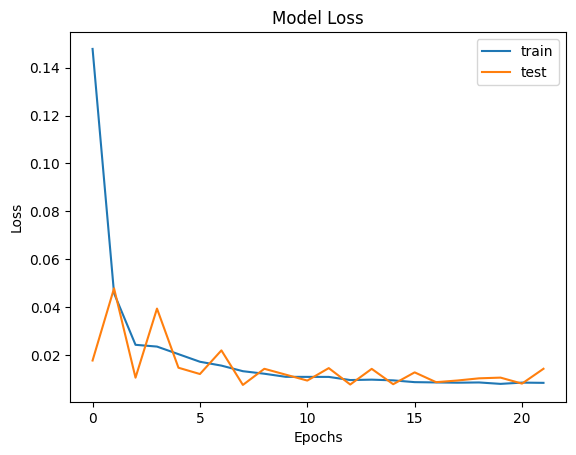

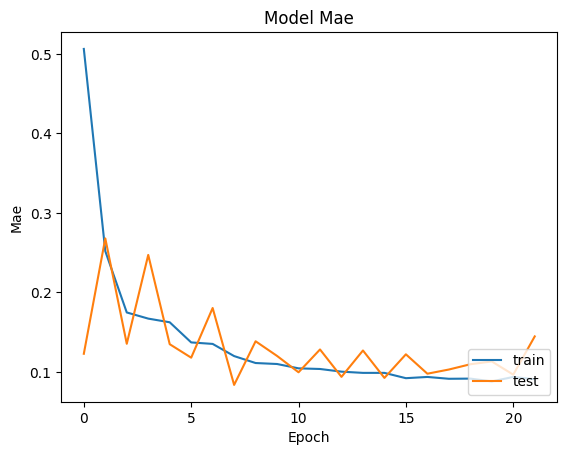

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [17]:
model.save("./temp_balikpapan.h5")

2/2 [==============================] - 2s 82ms/step


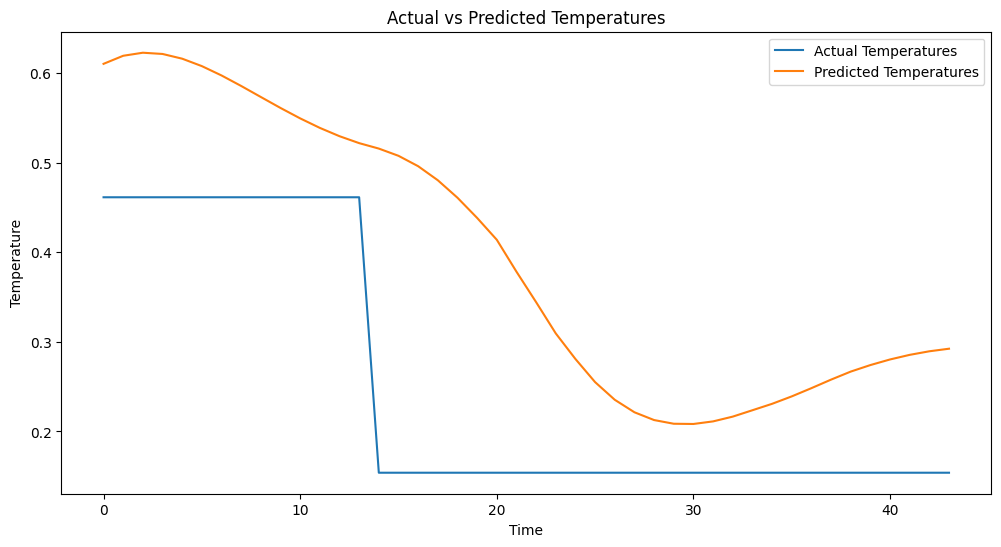

In [18]:
# Make predictions
predictions = model.predict(X_test)

# Create an array of dates corresponding to the test set
x_values = np.arange(len(y_test))

# Plot the predicted temperatures against the x-axis values
plt.figure(figsize=(12, 6))
plt.plot(x_values, y_test, label='Actual Temperatures')
plt.plot(x_values, predictions, label='Predicted Temperatures')
plt.title('Actual vs Predicted Temperatures')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [29]:
import datetime
import numpy as np
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("temp_balikpapan.h5")

def predict_temperature(year, month, day):
    # Tanggal yang akan diprediksi suhunya
    input_date = datetime.date(year, month, day)

    # Tentukan tanggal referensi
    reference_date = datetime.date(2015, 1, 1)

    # Hitung perbedaan hari antara tanggal input dan tanggal referensi
    delta_days = (input_date - reference_date).days

    # Ubah perbedaan hari menjadi representasi numerik
    input_date_representation = scaler.transform([[delta_days]])[0]

    time_step = 100  # Set the appropriate value based on your problem and data characteristics

    # Buat input data untuk prediksi
    input_data = []
    for i in range(len(data_1) - time_step + 1, len(data_1)):
        input_data.append(data_1[i, 0])
    input_data.append(input_date_representation[0])

    # Konversi input data menjadi array NumPy
    input_data = np.array(input_data)

    # Reshape input data menjadi bentuk yang dapat diterima oleh model
    input_data = np.reshape(input_data, (1, time_step, 1))

    # Lakukan prediksi suhu
    predicted_temperature = model.predict(input_data)

    # Reshape predicted_temperature to have the expected dimensions
    predicted_temperature = np.reshape(predicted_temperature, (1, 1))

    # Apply inverse_transform to convert the predicted_temperature to the original scale
    predicted_temperature = scaler.inverse_transform(predicted_temperature)[0][0]

    return predicted_temperature

# Contoh pemanggilan fungsi
year = 2023
month = 12
day = 1
predicted_temp = predict_temperature(year, month, day)
print(predicted_temp)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 2s 2s/step
27.609997
